Make Patches using pylidc
Reference : https://pylidc.github.io/

1. Annotation
2. Get volume of nodules
3. Get nodule index from boolean_mask
4. Make patches using MATLAB API

In [1]:
import numpy as np
import pylidc as pl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matlab.engine

In [14]:
anns = pl.query(pl.Annotation)\
        .filter(pl.Annotation.malignancy < 3)
print(anns.count())

2600


Loading dicom files ... This may take a moment.


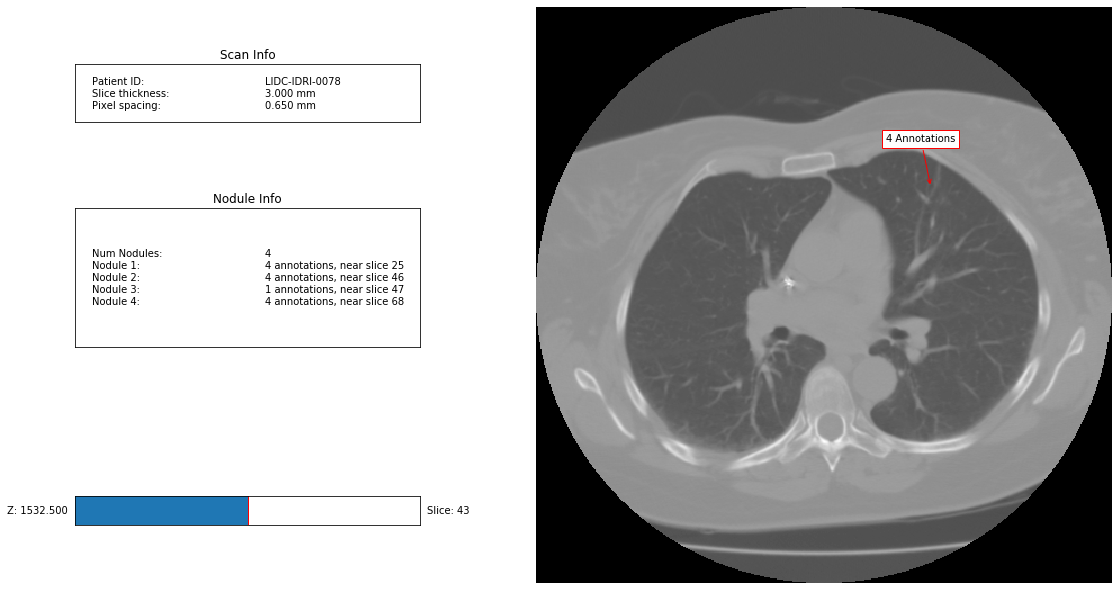

In [15]:
scan = pl.query(pl.Scan).first()
nodules = scan.cluster_annotations()

scan.visualize(annotation_groups=nodules)

In [ ]:
eng = matlab.engine.start_matlab()

In [ ]:
anns = pl.query(pl.Annotation)\
        .filter(pl.Annotation.malignancy == (1 or 2))

# Initializa the scaler
scaler = MinMaxScaler()

for i, ann in enumerate(anns):
    vol = ann.scan.to_volume()
    bbox = ann.bbox()
    mask = ann.boolean_mask()

    # Crop the nodule volume
    vol_nodule = vol[bbox]
    
    # Get the numbers of loop
    x,y,z = vol_nodule.shape
    for j in range(0, z):
        # Scaling the volume to [0, 1]
        scaler.fit(vol[bbox][:,:,j])
        vol_v2 = scaler.transform(vol[bbox][:,:,j])
        
        # Get the index of the nodule's edge
        arridx = np.where(mask[:,:,j] == 1)
        y_min = np.amin(arridx[0])
        y_max = np.amax(arridx[0])
        x_min = np.amin(arridx[1])
        x_max = np.amax(arridx[1])

        vol_v3 = vol_v2[y_min:y_max+1,x_min:x_max+1]
        
        vol_x1 = vol_v3 * 255
        vol_x2 = vol_x1.astype(int)
        
        # Since MATLAB function needs list as input parameter
        # You should convert ndarray to list
        vol_x3 = vol_x2.tolist()
        vol_x4 = matlab.uint8(vol_x3)
        
        # Since imwrite has no arguments, you should change 'nargout' to zero.
        # https://kr.mathworks.com/help/matlab/apiref/matlab.engine.matlabengine-class.html
        eng.imwrite(vol_x4, 
                    "Patches/Non-Nodules/nodule" + str(i) + "_" + str(j) + ".png", 
                    nargout=0) 

In [ ]:
scaler = MinMaxScaler()
scaler.fit(vol_v4)
vol_x1 = scaler.transform(vol_v4) * 255
vol_x2 = vol_x1.astype(int)

vol_x3 = vol_x2.tolist()
vol_x4 = matlab.uint8(vol_x3)
# Since imwrite has no arguments
# https://kr.mathworks.com/help/matlab/apiref/matlab.engine.matlabengine-class.html
eng.imwrite(vol_x4, "Patches/Nodules/nodule" + str(i) + "_" + str(j) + ".png", nargout=0) 